In [1]:
import numpy as np
from scipy.stats import norm, gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
from collections import OrderedDict
import wooldridge
from statsmodels.formula.api import ols

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

In [2]:
wagepan = wooldridge.data('wagepan')
wooldridge.data('wagepan', description=True)

name of dataset: wagepan
no of variables: 44
no of observations: 4360

+----------+------------------------+
| variable | label                  |
+----------+------------------------+
| nr       | person identifier      |
| year     | 1980 to 1987           |
| agric    | =1 if in agriculture   |
| black    | =1 if black            |
| bus      |                        |
| construc | =1 if in construction  |
| ent      |                        |
| exper    | labor mkt experience   |
| fin      |                        |
| hisp     | =1 if Hispanic         |
| poorhlth | =1 if in poor health   |
| hours    | annual hours worked    |
| manuf    | =1 if in manufacturing |
| married  | =1 if married          |
| min      |                        |
| nrthcen  | =1 if north central    |
| nrtheast | =1 if north east       |
| occ1     |                        |
| occ2     |                        |
| occ3     |                        |
| occ4     |                        |
| occ5     |     

In [3]:
# 説明変数のリスト
exog = ['married','union','expersq','d81','d82','d83','d84','d85','d86','d87']

# 全ての変数のリスト
var = ['lwage']+exog

# 使う変数だけで構成されるDataFrame
df = wagepan.loc[:,['nr']+var]

# varの平均からの乖離を計算（下の説明（１）を参照）
df_g = df.groupby('nr')
df_mean = df_g[var].transform('mean')
df_md = df.loc[:,var]-df_mean

# 説明変数の行列（下の説明（２）を参照）
X = df_md.loc[:,exog].values

# 被説明変数のベクトル
Y = df_md.loc[:,'lwage'].values

# OLSの計算
params = np.linalg.inv((X.T)@X)@(X.T)@Y

# 結果の表示（下の説明（３）を参照）
for idx, name in enumerate(exog):
    print(f'{name}: {params[idx]:.4}')

married: 0.04668
union: 0.08
expersq: -0.005185
d81: 0.1512
d82: 0.253
d83: 0.3544
d84: 0.4901
d85: 0.6175
d86: 0.7655
d87: 0.925


In [4]:
wagepan = wagepan.set_index(['nr','year'],drop=False)

In [5]:
wagepan.head()

nr  year  agric  black  bus  construc  ent  exper  fin  hisp  ...  \
nr year                                                                ...   
13 1980  13  1980      0      0    1         0    0      1    0     0  ...   
   1981  13  1981      0      0    0         0    0      2    0     0  ...   
   1982  13  1982      0      0    1         0    0      3    0     0  ...   
   1983  13  1983      0      0    1         0    0      4    0     0  ...   
   1984  13  1984      0      0    0         0    0      5    0     0  ...   

         union     lwage  d81  d82  d83  d84  d85  d86  d87  expersq  
nr year                                                               
13 1980      0  1.197540    0    0    0    0    0    0    0        1  
   1981      1  1.853060    1    0    0    0    0    0    0        4  
   1982      0  1.344462    0    1    0    0    0    0    0        9  
   1983      0  1.433213    0    0    1    0    0    0    0       16  
   1984      0  1.568125    0    0    0    1    0    0    0       25  

[5 rows x 44 columns]

In [6]:
wagepan.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4360 entries, (13, 1980) to (12548, 1987)
Data columns (total 44 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nr        4360 non-null   int64  
 1   year      4360 non-null   int64  
 2   agric     4360 non-null   int64  
 3   black     4360 non-null   int64  
 4   bus       4360 non-null   int64  
 5   construc  4360 non-null   int64  
 6   ent       4360 non-null   int64  
 7   exper     4360 non-null   int64  
 8   fin       4360 non-null   int64  
 9   hisp      4360 non-null   int64  
 10  poorhlth  4360 non-null   int64  
 11  hours     4360 non-null   int64  
 12  manuf     4360 non-null   int64  
 13  married   4360 non-null   int64  
 14  min       4360 non-null   int64  
 15  nrthcen   4360 non-null   int64  
 16  nrtheast  4360 non-null   int64  
 17  occ1      4360 non-null   int64  
 18  occ2      4360 non-null   int64  
 19  occ3      4360 non-null   int64  
 20  occ4      43

In [7]:
wagepanp = PanelData(wagepan)
wagepanp.shape

(44, 8, 545)

In [8]:
(~wagepanp.isnull).all()

True

In [9]:
formula_fe = 'lwage ~ married + union + expersq \
                      +d81+d82+d83+d84+d85+d86+d87 + EntityEffects'

In [10]:
mod_fe = PanelOLS.from_formula(formula_fe, data=wagepan)

In [11]:
result_fe = mod_fe.fit()

In [12]:
print(result_fe.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.0467     0.0183     2.5494     0.0108      0.0108      0.0826
union          0.0800     0.0193     4.1430     0.0000      0.0421      0.1179
expersq       -0.0052     0.0007    -7.3612     0.0000     -0.0066     -0.0038
d81            0.1512     0.0219     6.8883     0.0000      0.1082      0.1942
d82            0.2530     0.0244     10.360     0.0000      0.2051      0.3008
d83            0.3544     0.0292     12.121     0.0000      0.2971      0.4118
d84            0.4901     0.0362     13.529     0.0000      0.4191      0.5611
d85            0.6175     0.0452     13.648     0.0000      0.5288      0.7062
d86            0.7655     0.0561     13.638     0.0000      0.6555      0.8755
d87            0.9250     0.0688     13.450     0.00

In [13]:
print(result_fe.summary.tables[0])

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1806
Estimator:                   PanelOLS   R-squared (Between):              0.2386
No. Observations:                4360   R-squared (Within):               0.1806
Date:                Mon, Nov 09 2020   R-squared (Overall):              0.2361
Time:                        20:17:07   Log-likelihood                   -1324.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      83.851
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(10,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             83.851
                            

In [14]:
formula_fe2 = 'lwage ~ married + union + expersq + TimeEffects + EntityEffects'
result_fe2 = PanelOLS.from_formula(formula_fe2, data=wagepan).fit()
print(result_fe2)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0216
Estimator:                   PanelOLS   R-squared (Between):             -0.2717
No. Observations:                4360   R-squared (Within):              -0.4809
Date:                Mon, Nov 09 2020   R-squared (Overall):             -0.2808
Time:                        20:17:07   Log-likelihood                   -1324.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.959
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(3,3805)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             27.959
                            

In [15]:
formula_dum = 'lwage ~  1 + married + union + expersq \
                        +d81+d82+d83+d84+d85+d86+d87 + C(nr)'

In [16]:
result_dum = PooledOLS.from_formula(formula_dum, data=wagepan).fit()

In [17]:
filter = (result_dum.params.index.str.contains('nr') == False).tolist()
result_dum.params[filter]

Intercept    0.933291
married      0.046680
union        0.080002
expersq     -0.005185
d81          0.151191
d82          0.252971
d83          0.354444
d84          0.490115
d85          0.617482
d86          0.765497
d87          0.925025
Name: parameter, dtype: float64

In [18]:
formula_re = 'lwage ~ 1 + married + union + expersq \
                        + exper + educ + black + hisp \
                        +d81+d82+d83+d84+d85+d86+d87'

In [19]:
result_re = RandomEffects.from_formula(formula_re, data=wagepan).fit()

In [20]:
print(result_re.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0234     0.1514     0.1546     0.8771     -0.2735      0.3203
married        0.0638     0.0168     3.8035     0.0001      0.0309      0.0967
union          0.1059     0.0179     5.9289     0.0000      0.0709      0.1409
expersq       -0.0047     0.0007    -6.8623     0.0000     -0.0061     -0.0034
exper          0.1058     0.0154     6.8706     0.0000      0.0756      0.1361
educ           0.0919     0.0107     8.5744     0.0000      0.0709      0.1129
black         -0.1394     0.0480    -2.9054     0.0037     -0.2334     -0.0453
hisp           0.0217     0.0428     0.5078     0.6116     -0.0622      0.1057
d81            0.0404     0.0247     1.6362     0.1019     -0.0080      0.0889
d82            0.0309     0.0324     0.9519     0.34

In [21]:
result_re.theta.iloc[0,:]

theta    0.645059
Name: 13, dtype: float64

In [22]:
result_re.variance_decomposition

Effects                   0.106946
Residual                  0.123324
Percent due to Effects    0.464438
Name: Variance Decomposition, dtype: float64

In [23]:
def add_col_mean(dframe, ori_col, new_col):  # (1)
    
    dict = dframe.groupby(level=0)[ori_col].mean().to_dict()  # (2)
    mean = dframe.index.get_level_values(0).to_series().map(dict).tolist()  # (3)
    dframe.loc[:,new_col] = mean  # (4)
    
    return dframe   # (5)

In [24]:
wagepan = add_col_mean(wagepan, 'married', 'married_mean')
wagepan = add_col_mean(wagepan, 'union', 'union_mean')
wagepan = add_col_mean(wagepan, 'expersq', 'expersq_mean')

In [25]:
formula_cre = 'lwage ~ 1 + married + union + expersq \
                         + married_mean + union_mean + expersq_mean \
                         +d81+d82+d83+d84+d85+d86+d87'

result_cre = RandomEffects.from_formula(formula_cre, data=wagepan).fit()

print(result_cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lwage   R-squared:                        0.1711
Estimator:              RandomEffects   R-squared (Between):              0.0967
No. Observations:                4360   R-squared (Within):               0.1806
Date:                Mon, Nov 09 2020   R-squared (Overall):              0.1355
Time:                        20:17:08   Log-likelihood                   -1609.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      69.027
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                 F(13,4346)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             69.027
                            

In [26]:
# 検定する係数の値を設定する
restriction = 'married_mean = union_mean = expersq_mean = 0'

# 検定結果を表示する
result_cre.wald_test(formula=restriction)

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 35.6454
P-value: 0.0000
Distributed: chi2(3)
WaldTestStatistic, id: 0x7fd9e9996670

In [27]:
formula_cre2 = 'lwage ~ 1 + married + union + expersq \
                          + exper + educ + black + hisp \
                          + married_mean + union_mean + expersq_mean \
                          +d81+d82+d83+d84+d85+d86+d87'

result_cre2 = RandomEffects.from_formula(formula_cre2, data=wagepan).fit()

print(result_cre2.summary.tables[1])

                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept       -0.1288     0.1583    -0.8140     0.4157     -0.4391      0.1814
married          0.0467     0.0183     2.5520     0.0107      0.0108      0.0825
union            0.0800     0.0193     4.1473     0.0000      0.0422      0.1178
expersq         -0.0052     0.0007    -7.3689     0.0000     -0.0066     -0.0038
exper           -0.0504     0.0507    -0.9947     0.3200     -0.1499      0.0490
educ             0.0946     0.0110     8.6115     0.0000      0.0731      0.1161
black           -0.1388     0.0492    -2.8193     0.0048     -0.2353     -0.0423
hisp             0.0048     0.0430     0.1110     0.9116     -0.0795      0.0891
married_mean     0.0970     0.0454     2.1382     0.0326      0.0081      0.1859
union_mean       0.1907     

In [28]:
result_cre2.wald_test(formula=restriction)

Linear Equality Hypothesis Test
H0: Linear equality constraint is valid
Statistic: 26.0233
P-value: 0.0000
Distributed: chi2(3)
WaldTestStatistic, id: 0x7fd9d1091fd0

In [29]:
formula_pool = 'lwage ~ 1 + married + union + expersq \
                        + exper + educ + black + hisp \
                        +d81+d82+d83+d84+d85+d86+d87'

result_pool = PooledOLS.from_formula(formula_pool, data=wagepan).fit()

print(result_pool.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0921     0.0783     1.1761     0.2396     -0.0614      0.2455
married        0.1083     0.0157     6.8997     0.0000      0.0775      0.1390
union          0.1825     0.0172     10.635     0.0000      0.1488      0.2161
expersq       -0.0024     0.0008    -2.9413     0.0033     -0.0040     -0.0008
exper          0.0672     0.0137     4.9095     0.0000      0.0404      0.0941
educ           0.0913     0.0052     17.442     0.0000      0.0811      0.1016
black         -0.1392     0.0236    -5.9049     0.0000     -0.1855     -0.0930
hisp           0.0160     0.0208     0.7703     0.4412     -0.0248      0.0568
d81            0.0583     0.0304     1.9214     0.0548     -0.0012      0.1178
d82            0.0628     0.0332     1.8900     0.05

In [30]:
res = {'Pooled OLS':result_pool,
       'FE': result_fe,
       'RE': result_re,
       'CRE': result_cre2
      }

# compare(res)

In [31]:
res_ordered = OrderedDict(res)
print(compare(res_ordered))

                                     Model Comparison                                    
                            Pooled OLS             FE                RE               CRE
-----------------------------------------------------------------------------------------
Dep. Variable                    lwage          lwage             lwage             lwage
Estimator                    PooledOLS       PanelOLS     RandomEffects     RandomEffects
No. Observations                  4360           4360              4360              4360
Cov. Est.                   Unadjusted     Unadjusted        Unadjusted        Unadjusted
R-squared                       0.1893         0.1806            0.1806            0.1855
R-Squared (Within)              0.1692         0.1806            0.1799            0.1806
R-Squared (Between)             0.2066         0.2386            0.1853            0.2192
R-Squared (Overall)             0.1893         0.2361            0.1828            0.2013
F-statisti

In [32]:
b0 = 1  # 定数項
b1 = 2  # スロープ係数

In [33]:
N = 100  # 観察単位の数
T = 5  # 時間数
ai = np.linspace(0,10,N)  # 観察単位の異質性

In [34]:
df_sim = pd.DataFrame()  # 空のDataFrame

for (idx,a) in enumerate(ai):
    
    x = norm.rvs(a,1,size=T)  # T個のaが平均となるランダムな数
    u = norm.rvs(0,1,size=T)  # 誤差項
    y = b0 + b1*x + a + u  # 被説明変数
    df_idx = pd.DataFrame({'id':[idx]*T,    # 観察個体のID
                         'time':np.array(range(T))+2000,
                         'Y':y,
                         'X':x,
                         'ai':[a]*T})
    df_sim = pd.concat([df_sim,df_idx])

In [35]:
# id と time の列を 整数型に変換（省いても問題ない）
df_sim['id'] = df_sim['id'].astype(int)
df_sim['time'] = df_sim['time'].astype(int)

# MultiIndex化
df_sim = df_sim.set_index(['id','time'])

df_sim.head()

Y         X   ai
id time                         
0  2000  6.787173  1.878080  0.0
   2001  2.002697  0.296177  0.0
   2002  0.154992  0.100644  0.0
   2003  1.422849  0.813714  0.0
   2004 -1.485872 -1.120546  0.0

In [36]:
form_sim_fe = 'Y ~ X + EntityEffects'

sim_fe = PanelOLS.from_formula(form_sim_fe, data=df_sim).fit()

print(sim_fe.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
X              2.0624     0.0504     40.929     0.0000      1.9633      2.1614


In [37]:
form_sim_re = 'Y ~ 1 + X'

sim_re = RandomEffects.from_formula(form_sim_re, data=df_sim).fit()

print(sim_re.summary.tables[1])
print('theta:', sim_re.theta.iloc[0,:].values)

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.8825     0.1567     12.015     0.0000      1.5746      2.1903
X              2.8147     0.0263     107.18     0.0000      2.7631      2.8663
theta: [0.32565416]


In [38]:
df_sim = add_col_mean(df_sim, 'X', 'X_mean')

In [39]:
form_sim_cre = 'Y ~ 1 + X + X_mean'

sim_cre = RandomEffects.from_formula(form_sim_cre, data=df_sim).fit()

print(sim_cre.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.0751     0.1358     7.9156     0.0000      0.8083      1.3420
X              2.0624     0.0504     40.961     0.0000      1.9634      2.1613
X_mean         0.9133     0.0555     16.452     0.0000      0.8042      1.0224


In [40]:
form_sim_pool = 'Y ~ 1 + X'

sim_pool = PooledOLS.from_formula(form_sim_pool, data=df_sim).fit()

print(sim_pool.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.4813     0.1195     12.392     0.0000      1.2464      1.7161
X              2.8947     0.0203     142.43     0.0000      2.8548      2.9346


In [41]:
N = 100  # 観察単位数
T = 5  # 年数
R = 100  # シミュレーションの回数
ai = np.linspace(0,10,N)  # 観察単位の異質性

In [42]:
bhat_fe_list = []  # FE推定値を入れるための空のリスト
bhat_re_list = []  # RE推定値を入れるための空のリスト
bhat_pool_list = []  # Pooled OLS推定値を入れるための空のリスト

for _ in range(R):  # Rの値は下のコードで使わないので"_"に設定する
    
    df = pd.DataFrame()  # 空のDataFrame

    # データの生成
    for (idx,a) in enumerate(ai):
        x = norm.rvs(a,1,size=T)  # T個のaが平均となるランダムな数
        u = norm.rvs(0,1,size=T)  # T個の誤差項
        y = b0 + b1*x + a + u  # T個の被説明変数
        df_idx = pd.DataFrame({'id':[idx]*T,      # DataFrameへ表の追加
                             'time':np.array(range(T))+2000,
                             'Y':y,
                             'X':x,
                             'ai':[a]*T})
        df = pd.concat([df,df_idx])
        
    # RE推定
    df_re = df.set_index(['id','time'])  # MultiIndex化
    form_sim_re = 'Y ~ 1 + X'
    sim_re = RandomEffects.from_formula(form_sim_re, data=df_re).fit()
    bhat_re_list.append(sim_re.params[1])

    # FE推定
    df_fe = df.loc[:,['Y','X']] - df.groupby('id')[['Y','X']].transform('mean')
    Yfe = df_fe.loc[:,'Y'].values
    Xfe = df_fe.loc[:,'X'].values[:,None]  # [:,None]は(N*T,1)の行列に変換
    bhat_fe = (np.linalg.inv(Xfe.T@Xfe)@Xfe.T@Yfe)[0]
    bhat_fe_list.append(bhat_fe)
    
    # Pooled OLS推定
    c = np.ones(N*T)
    Xpool = np.stack([c, df.loc[:,'X'].values], axis=1)
    Ypool = df.loc[:,'Y'].values
    bhat_pool = (np.linalg.inv(Xpool.T@Xpool)@Xpool.T@Ypool)[1]
    bhat_pool_list.append(bhat_pool)

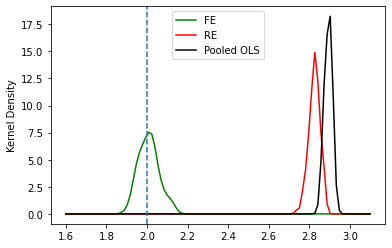

In [43]:
xx=np.linspace(1.6,3.1,num=100)  # 図を作成するために横軸の値を設定

kde_model_fe=gaussian_kde(bhat_fe_list)  # FE推定量のカーネル密度関数を計算

kde_model_re=gaussian_kde(bhat_re_list)  # RE推定量のカーネル密度関数を計算

kde_model_pool=gaussian_kde(bhat_pool_list)  # Pooled OLS推定量のカーネル密度関数を計算

plt.plot(xx, kde_model_fe(xx), 'g-', label='FE')  # FE推定量の分布プロット
plt.plot(xx, kde_model_re(xx),'r-', label='RE')  # RE推定量の分布プロット
plt.plot(xx, kde_model_pool(xx),'k-', label='Pooled OLS')  # RE推定量の分布プロット
plt.axvline(x=b1,linestyle='dashed')  # 真の値での垂直線
plt.ylabel('Kernel Density')  # 縦軸のラベル
plt.legend()  # 凡例
pass

In [44]:
# 残差
u_hat = result_fe.resids.values.flatten()

# 被説明変数の予測値
y_hat = result_fe.fitted_values.values.flatten()

# DataFrameの作成
df_white = pd.DataFrame({'u_hat':u_hat,'y_hat':y_hat})

In [45]:
form_white = 'I(u_hat**2) ~ y_hat + I(y_hat**2)'

res_white = ols(form_white, data=df_white).fit()

print(res_white.summary().tables[1])
print('F検定のp値：',res_white.f_pvalue)

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.1172      0.010     11.249      0.000       0.097       0.138
y_hat            -0.0205      0.048     -0.428      0.668      -0.114       0.073
I(y_hat ** 2)    -0.0550      0.099     -0.557      0.577      -0.248       0.138
F検定のp値： 0.4354339447413128


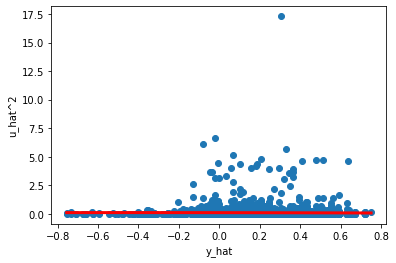

In [46]:
b0 = res_white.params[0] # beta0
b1 = res_white.params[1] # beta1
b2 = res_white.params[2] # beta2

xx = np.linspace(min(y_hat), max(y_hat), 100) # x軸の値
z = b0 + b1*xx + b1*xx**2  # 検定に使った式

plt.scatter(y_hat, u_hat**2)  # u_hat, y_hatの散布図
plt.plot(xx, z, 'red', linewidth=3)  # 検定の式の曲線
plt.xlabel('y_hat')
plt.ylabel('u_hat^2')
pass

In [47]:
mod_fe_clus1 = PanelOLS.from_formula(formula_fe, data=wagepan)

res_fe_clus1 = mod_fe_clus1.fit(cov_type='clustered', cluster_entity=True)

print(res_fe_clus1.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.0467     0.0210     2.2245     0.0262      0.0055      0.0878
union          0.0800     0.0227     3.5209     0.0004      0.0355      0.1246
expersq       -0.0052     0.0008    -6.4058     0.0000     -0.0068     -0.0036
d81            0.1512     0.0255     5.9195     0.0000      0.1011      0.2013
d82            0.2530     0.0286     8.8340     0.0000      0.1968      0.3091
d83            0.3544     0.0348     10.177     0.0000      0.2862      0.4227
d84            0.4901     0.0454     10.792     0.0000      0.4011      0.5792
d85            0.6175     0.0568     10.879     0.0000      0.5062      0.7288
d86            0.7655     0.0712     10.755     0.0000      0.6259      0.9050
d87            0.9250     0.0840     11.015     0.00

In [48]:
mod_fe_clus2 = PanelOLS.from_formula(formula_fe, data=wagepan)

res_fe_clus2 = mod_fe_clus2.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)

print(res_fe_clus2.summary.tables[1])

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
married        0.0467     0.0165     2.8312     0.0047      0.0144      0.0790
union          0.0800     0.0234     3.4242     0.0006      0.0342      0.1258
expersq       -0.0052     0.0008    -6.6189     0.0000     -0.0067     -0.0036
d81            0.1512     0.0066     23.020     0.0000      0.1383      0.1641
d82            0.2530     0.0168     15.027     0.0000      0.2200      0.2860
d83            0.3544     0.0255     13.886     0.0000      0.3044      0.4045
d84            0.4901     0.0374     13.113     0.0000      0.4168      0.5634
d85            0.6175     0.0499     12.366     0.0000      0.5196      0.7154
d86            0.7655     0.0646     11.858     0.0000      0.6389      0.8921
d87            0.9250     0.0776     11.913     0.00